When you run pywt.dwt2, it performs the following filtering operations:

LL (Approximation): Low-pass on rows, Low-pass on columns. This is a blurred, half-resolution version of the original image.

LH (Horizontal Detail): Low-pass on rows, High-pass on columns. This highlights horizontal edges.

HL (Vertical Detail): High-pass on rows, Low-pass on columns. This highlights vertical edges.

HH (Diagonal Detail): High-pass on rows, High-pass on columns. This highlights diagonal features and noise.


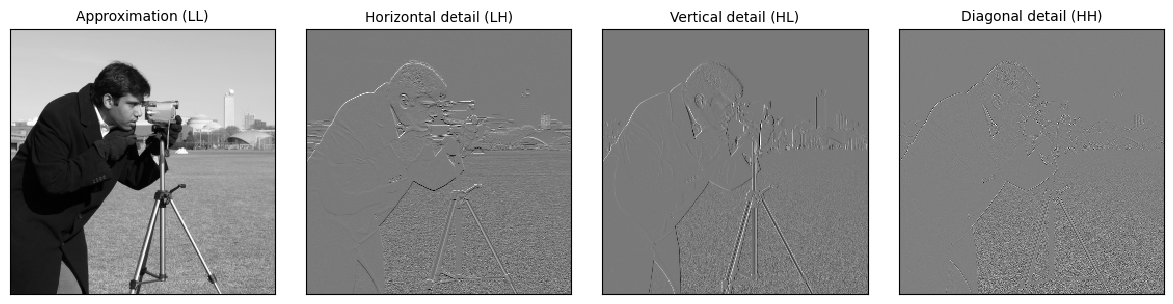

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pywt.data

# 1. Load a 2D Signal (Image)
original = pywt.data.camera()

# 2. Perform 2D DWT
# coeffs2 is a tuple: (cA, (cH, cV, cD))
coeffs2 = pywt.dwt2(original, 'haar')
cA, (cH, cV, cD) = coeffs2

# 3. Visualization
titles = ['Approximation (LL)', 'Horizontal detail (LH)',
          'Vertical detail (HL)', 'Diagonal detail (HH)']
images = [cA, cH, cV, cD]

fig = plt.figure(figsize=(12, 3))
for i, a in enumerate(images):
    ax = fig.add_subplot(1, 4, i + 1)
    ax.imshow(a, interpolation="nearest", cmap=plt.cm.gray)
    ax.set_title(titles[i], fontsize=10)
    ax.set_xticks([])
    ax.set_yticks([])

fig.tight_layout()
plt.show()

In [2]:
original = pywt.data.camera()

# 1. Multi-level Decomposition
# 'level=3' will decompose the LL quadrant 3 times.
level = 3
coeffs = pywt.wavedec2(original, 'haar', level=level)

# 2. Understanding the Structure
# coeffs[0] is the smallest Approximation (LL)
# coeffs[1] is a tuple (LH, HL, HH) for Level 3 (coarsest details)
# coeffs[2] is a tuple (LH, HL, HH) for Level 2
# coeffs[3] is a tuple (LH, HL, HH) for Level 1 (finest details)

# 3. Visualization
# Let's look at the smallest "Father" (Approximation) 
# and the "Mother" (Details) from the deepest level.
cA3 = coeffs[0]
(cH3, cV3, cD3) = coeffs[1]

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
axes[0].imshow(cA3, cmap='gray')
axes[0].set_title("Smallest Father (A3)")

axes[1].imshow(cH3, cmap='gray')
axes[1].set_title("Coarse Horizontal (H3)")

axes[2].imshow(cV3, cmap='gray')
axes[2].set_title("Coarse Vertical (V3)")

axes[3].imshow(cD3, cmap='gray')
axes[3].set_title("Coarse Diagonal (D3)")

for ax in axes:
    ax.axis('off')

plt.tight_layout()
plt.show()

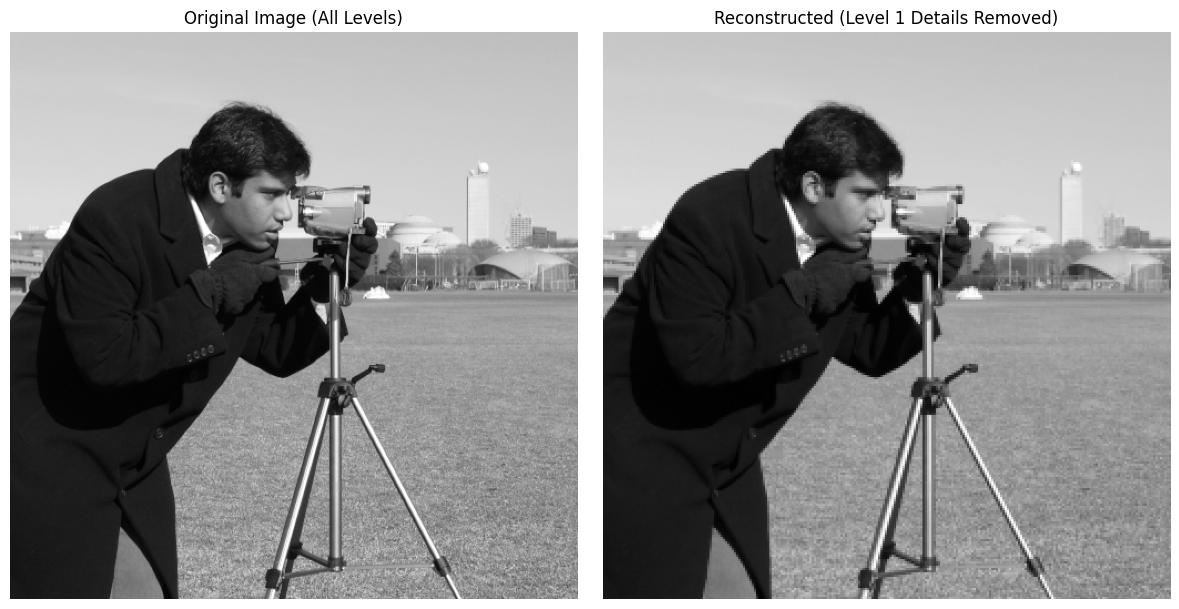

In [3]:
# 1. Decompose to 3 Levels
original = pywt.data.camera().astype(np.float32)
wavelet = 'haar'
level = 3
coeffs = pywt.wavedec2(original, wavelet, level=level)

# 2. Remove Level 1 Details
# Structure of 'coeffs' in wavedec2: [cA3, (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1)]
# coeffs[-1] is always the Level 1 detail tuple.
coeffs_filtered = list(coeffs) 

# Create zeros for the Level 1 Mother coefficients (Horizontal, Vertical, Diagonal)
cH1_zero = np.zeros_like(coeffs[-1][0])
cV1_zero = np.zeros_like(coeffs[-1][1])
cD1_zero = np.zeros_like(coeffs[-1][2])

# Replace the Level 1 tuple with zeros
coeffs_filtered[-1] = (cH1_zero, cV1_zero, cD1_zero)

# 3. Reconstruct
# Using waverec2 to put the Father and remaining Mothers back together
reconstructed_img = pywt.waverec2(coeffs_filtered, wavelet)

# 4. Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].imshow(original, cmap='gray')
axes[0].set_title("Original Image (All Levels)")
axes[0].axis('off')

axes[1].imshow(reconstructed_img, cmap='gray')
axes[1].set_title("Reconstructed (Level 1 Details Removed)")
axes[1].axis('off')

plt.tight_layout()
plt.show() 

In [4]:
# 1. Prepare Image
original = pywt.data.camera().astype(np.float32)
# Add some artificial noise
noise_sigma = 20
noisy_img = original + np.random.normal(0, noise_sigma, original.shape)

# 2. Multi-level Decomposition
wavelet = 'db4'
level = 3
coeffs = pywt.wavedec2(noisy_img, wavelet, level=level)

# 3. Apply Thresholding
# We calculate a threshold (Universal Threshold)
# sigma = median(|D1|) / 0.6745 is a common estimate
d1_flattened = np.concatenate([c.flatten() for c in coeffs[-1]])
sigma = np.median(np.abs(d1_flattened)) / 0.6745
threshold = sigma * np.sqrt(2 * np.log(original.size))

# Apply threshold to all Detail levels (Mother components)
# We leave the Approximation (Father) alone!
new_coeffs = [coeffs[0]] # Keep A3
for i in range(1, len(coeffs)):
    new_coeffs.append(tuple(pywt.threshold(c, threshold, mode='soft') for c in coeffs[i]))

# 4. Reconstruct
denoised_img = pywt.waverec2(new_coeffs, wavelet)

# 5. Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(original, cmap='gray')
axes[0].set_title("Original")
axes[1].imshow(noisy_img, cmap='gray')
axes[1].set_title(f"Noisy (sigma={noise_sigma})")
axes[2].imshow(denoised_img, cmap='gray')
axes[2].set_title("Wavelet Denoised (Soft Threshold)")

for ax in axes:
    ax.axis('off')
plt.show()

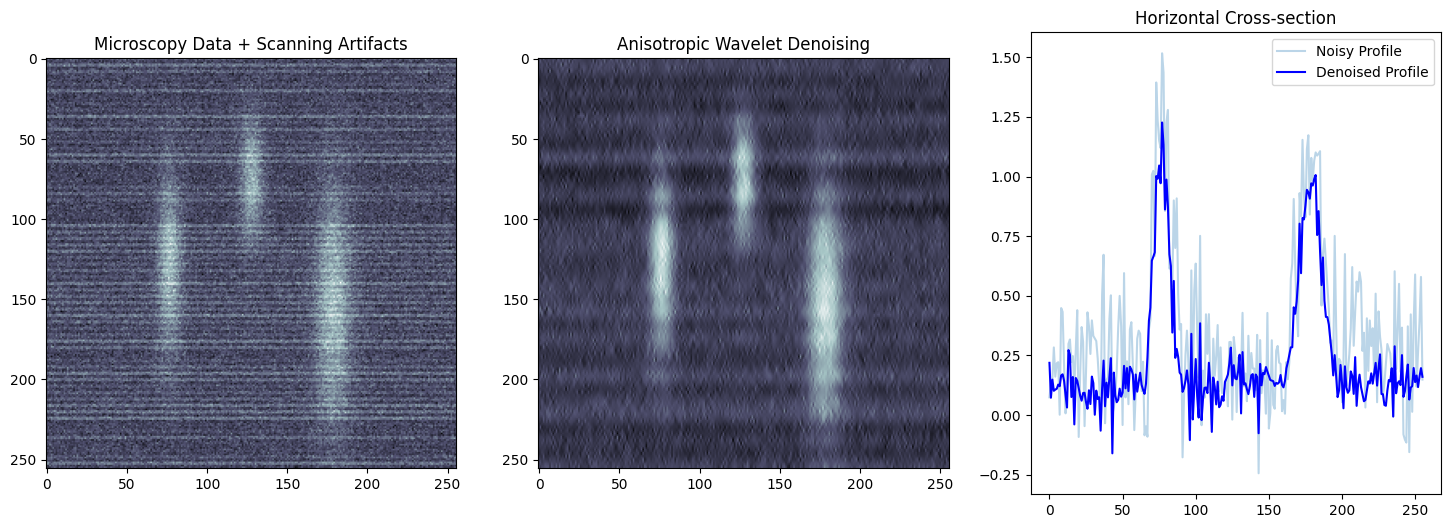

In [5]:
N = 256
t = np.linspace(0, 1, N)
X, Y = np.meshgrid(t, t)

def make_cell(x0, y0, sigma_x, sigma_y):
    return np.exp(-((X-x0)**2/(2*sigma_x**2) + (Y-y0)**2/(2*sigma_y**2)))

cells = make_cell(0.3, 0.5, 0.02, 0.15) + \
        make_cell(0.5, 0.3, 0.02, 0.1) + \
        make_cell(0.7, 0.6, 0.03, 0.2)

# 2. Add Anisotropic Noise (Horizontal "streaks" from a bad scanner)
noise = np.random.normal(0, 0.2, (N, N))
for i in range(0, N, 4):
    noise[i:i+2, :] += 0.5 * np.random.rand()

noisy_cells = cells + noise

# 3. Multilevel Separable Decomposition
wavelet = 'sym8'
coeffs = pywt.wavedec2(noisy_cells, wavelet, level=3)

# 4. Use Case Strategy: Directional Filtering, streaks are horisontal, cells are vertical
def directional_denoise(coeffs, h_lam, v_lam, d_lam):
    new_coeffs = [coeffs[0]] 
    for i in range(1, len(coeffs)):
        cH, cV, cD = coeffs[i]
      
        cH_t = pywt.threshold(cH, h_lam, mode='soft')

        cV_t = pywt.threshold(cV, v_lam, mode='soft')
    
        cD_t = pywt.threshold(cD, d_lam, mode='soft')
        new_coeffs.append((cH_t, cV_t, cD_t))
    return new_coeffs


processed_coeffs = directional_denoise(coeffs, h_lam=1.2, v_lam=0.1, d_lam=1.2)
denoised_cells = pywt.waverec2(processed_coeffs, wavelet)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
axes[0].imshow(noisy_cells, cmap='bone')
axes[0].set_title("Microscopy Data + Scanning Artifacts")

axes[1].imshow(denoised_cells, cmap='bone')
axes[1].set_title("Anisotropic Wavelet Denoising")

# Cross-section to show the cell profile preservation
axes[2].plot(noisy_cells[N//2, :], alpha=0.3, label="Noisy Profile")
axes[2].plot(denoised_cells[N//2, :], color='blue', label="Denoised Profile")
axes[2].set_title("Horizontal Cross-section")
axes[2].legend()

plt.show()

Raw data contains "Fuzz" (high-frequency noise) and "Drift" (low-frequency trends) that hide the true signal.

1. Start with stacking multiple signals into a 2D image to process simultaneoulsy. 

2. Apply thresholding to the Horizontal and Diagonal details to delete noise.

3. We isolate the Approximation (LL) sub-band, which represents the slow drift, and subtract it from the signal.

4. The result is a centered, clean signal that preserves sharp edges better than standard 1D filters.

c:\Users\User\Desktop\WaveLets\.venv\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 6 is too high: all coefficients will experience boundary effects.
  warnings.warn(


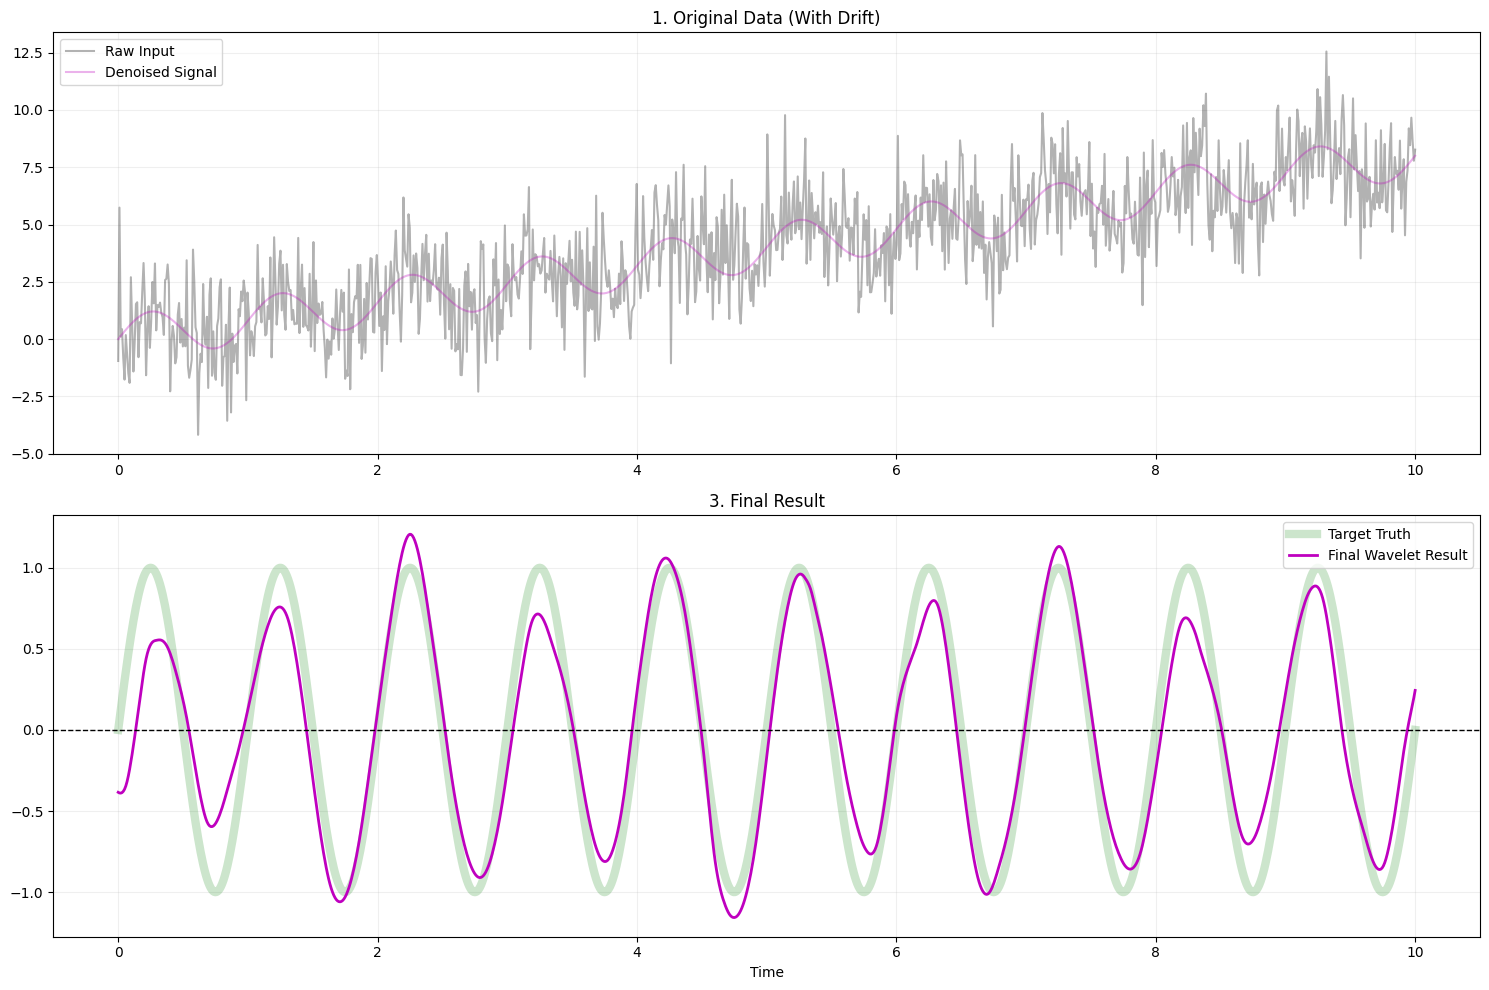

In [10]:

np.random.seed(0)

# 1. DATA GENERATION
n_sensors, n_timepoints = 50, 1024
t = np.linspace(0, 10, n_timepoints)
base_signal = np.sin(2 * np.pi * 1.0 * t)
trend_matrix = (0.8 * t) + np.random.normal(0, 1.5, (n_sensors, n_timepoints))
signal_trend = np.tile(base_signal, (n_sensors, 1)) + (0.8 * t)
data_2d = np.tile(base_signal, (n_sensors, 1)) + trend_matrix + np.random.normal(0, 0.5, (n_sensors, n_timepoints))

# 2. THE OPTIMIZED UNIFIED PASS
wavelet = 'sym8'
level = 6 
coeffs = pywt.wavedec2(data_2d, wavelet, level=level, mode='reflect')

# A. Kill the Trend: Set the approximation (cA5) to zero
coeffs[0] = np.zeros_like(coeffs[0])

# 2. SELECTIVE SMOOTHING (Kill the high-frequency jitter)
# If you want to keep the signal but kill the sharpest noise:
for i in range(1, len(coeffs)):
    cH, cV, cD = coeffs[i]
    thresh = (np.median(np.abs(cD)) / 0.6745) * np.sqrt(2 * np.log(cD.size))
    coeffs[i] = (
        pywt.threshold(cH, thresh, mode='soft'),
        pywt.threshold(cV, thresh, mode='soft'),
        pywt.threshold(cD, thresh, mode='soft')
    )

# Final result is smoothed and detrended in one step
final_cleaned = pywt.waverec2(coeffs, wavelet, mode='reflect')

# 3. VISUALIZATION 
sensor_idx = 10
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(t, data_2d[sensor_idx], 'k', alpha=0.3, label='Raw Input')
plt.plot(t, signal_trend[sensor_idx],'m', alpha = 0.3, label = 'Denoised Signal')
plt.title("1. Original Data (With Drift)"); plt.legend(); plt.grid(True, alpha=0.2)

plt.subplot(2, 1, 2)
plt.plot(t, base_signal, 'g', lw=6, alpha=0.2, label='Target Truth')
plt.plot(t, final_cleaned[sensor_idx], 'm', lw=2, label='Final Wavelet Result')
plt.axhline(0, color='black', lw=1, ls='--')
plt.title("3. Final Result"); plt.xlabel("Time"); plt.legend(); plt.grid(True, alpha=0.2)

plt.tight_layout()
plt.show()

c:\Users\User\Desktop\WaveLets\.venv\Lib\site-packages\pywt\_multilevel.py:43: UserWarning: Level value of 3 is too high: all coefficients will experience boundary effects.
  warnings.warn(


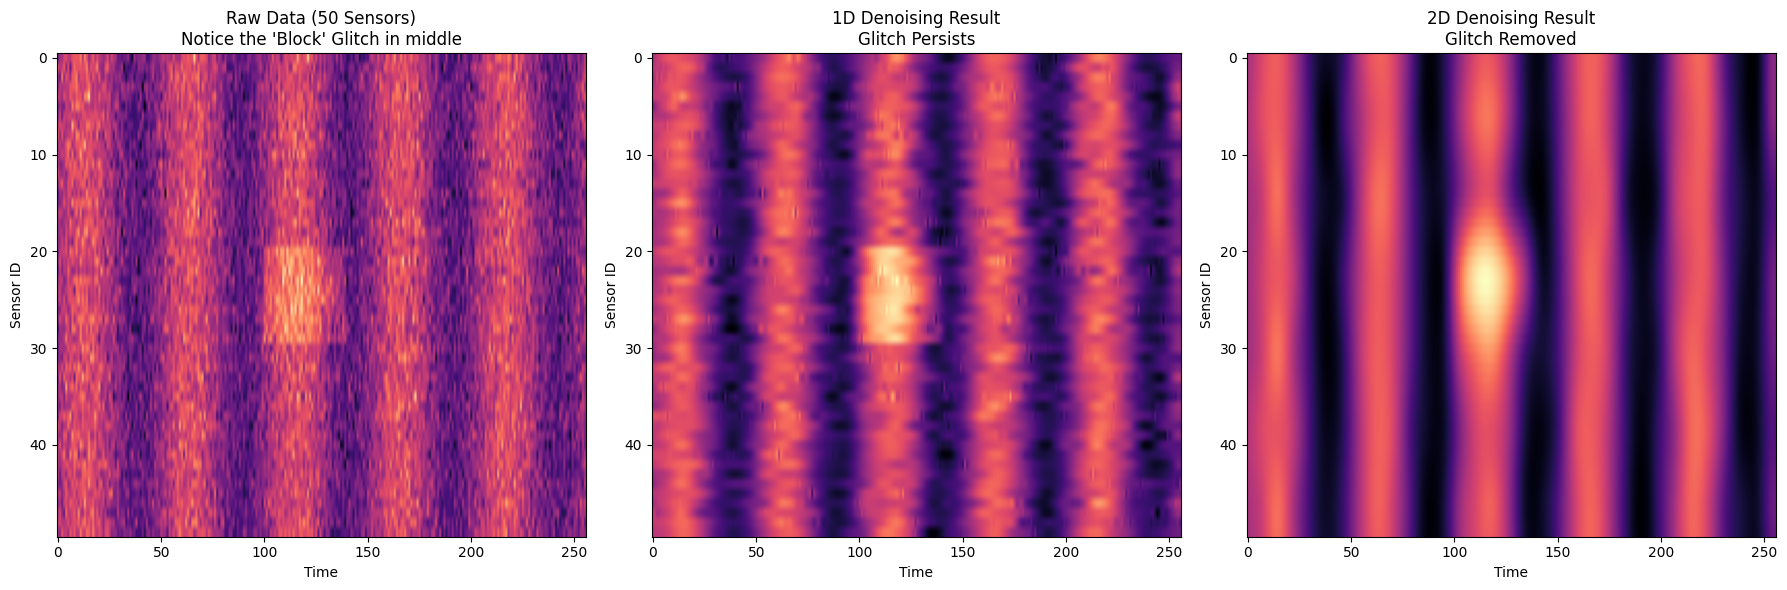

In [7]:
# 1. Create 50 sensors with a shared signal + individual noise
N_sensors = 50
N_time = 256
t = np.linspace(0, 1, N_time)
base_signal = np.sin(2 * np.pi * 5 * t)

# Stack them
data_2d = np.tile(base_signal, (N_sensors, 1))

# THE PROBLEM: A burst of noise hits ONLY sensors 20-30 at the same time. 

data_2d[20:30, 100:140] += 1

data_2d += np.random.normal(0, 0.5, (N_sensors, N_time))

# 2. SOLUTION A: 1D Denoising (Looping through each sensor)
denoised_1d = np.zeros_like(data_2d)
for i in range(N_sensors):
    coeffs_1d = pywt.wavedec(data_2d[i], 'sym8', level=3, mode='reflect')
    coeffs_1d[1:] = [pywt.threshold(c, 1.0, mode='soft') for c in coeffs_1d[1:]]
    denoised_1d[i] = pywt.waverec(coeffs_1d, 'sym8')

# 3. SOLUTION B: 2D Denoising (Separable)
coeffs_2d = pywt.wavedec2(data_2d, 'sym8', level=3, mode='reflect')

cA, (cH3, cV3, cD3), (cH2, cV2, cD2), (cH1, cV1, cD1) = coeffs_2d

def kill_glitch(H, V, D, amt=5.0):
    return (pywt.threshold(H, amt), pywt.threshold(V, amt), pywt.threshold(D, amt))

threshold = 5
c3_new = kill_glitch(cH3, cV3, cD3, amt=threshold)
c2_new = kill_glitch(cH2, cV2, cD2, amt=threshold)
c1_new = kill_glitch(cH1, cV1, cD1, amt=threshold)

denoised_2d = pywt.waverec2([cA, c3_new, c2_new, c1_new], 'sym8')

# VISUALIZATION: THE 2D HEATMAP
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].imshow(data_2d, aspect='auto', cmap='magma')
axes[0].set_title("Raw Data (50 Sensors)\nNotice the 'Block' Glitch in middle")

axes[1].imshow(denoised_1d, aspect='auto', cmap='magma')
axes[1].set_title("1D Denoising Result\nGlitch Persists")

axes[2].imshow(denoised_2d, aspect='auto', cmap='magma')
axes[2].set_title("2D Denoising Result\nGlitch Removed")

for ax in axes: ax.set_xlabel("Time"); ax.set_ylabel("Sensor ID")
plt.tight_layout()
plt.show()

In [ ]:
# 1. --- DATA GENERATION (The "Problem") ---
N_sensors, N_time = 50, 256
t = np.linspace(0, 1, N_time)
# Shared signal across all sensors
base_signal = np.sin(2 * np.pi * 5 * t)
data_2d = np.tile(base_signal, (N_sensors, 1))

# Add a "Stronger than Signal" Glitch
data_2d[20:35, 110:210] += 5.0 
# Add random background noise
data_2d += np.random.normal(0, 0.4, (N_sensors, N_time))


def auto_clean_2d(data, wavelet='sym8', level=3, sigma_factor=4):
    coeffs = pywt.wavedec2(data, wavelet, level=level, mode='reflect')
    cA = coeffs[0]
    details = coeffs[1:]
    
    clean_details = []
    for i, (H, V, D) in enumerate(details):
        # Calculate Robust Threshold (Median Absolute Deviation)
        # We use the Diagonal band to estimate noise floor
        sigma = np.median(np.abs(D)) / 0.6745
        thresh = sigma * sigma_factor
        print(f"threshold value {thresh}")
        mask = (np.abs(V) > thresh) | (np.abs(D) > thresh)

        H[mask], V[mask], D[mask] = 0, 0, 0
        clean_details.append((H, V, D))
    
    sigma_a = np.median(np.abs(cA)) / 0.6745
    cA[np.abs(cA) > (sigma_a * sigma_factor)] = 0
    
    return pywt.waverec2([cA, *clean_details], wavelet)


denoised_1d = np.zeros_like(data_2d)
for i in range(N_sensors):
    c_1d = pywt.wavedec(data_2d[i], 'sym8', level=3, mode='reflect')
    c_1d[1:] = [pywt.threshold(c, 1.5, mode='soft') for c in c_1d[1:]]
    denoised_1d[i] = pywt.waverec(c_1d, 'sym8')

# 4. --- EXECUTION & VISUALIZATION ---
cleaned_2d = auto_clean_2d(data_2d)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
titles = ["Raw Data (Glitch > Signal)", "1D Cleanup", "2D Auto-Cleanup"]
imgs = [data_2d, denoised_1d, cleaned_2d]

for ax, img, title in zip(axes, imgs, titles):
    im = ax.imshow(img, aspect='auto', cmap='magma')
    ax.set_title(title)
    plt.colorbar(im, ax=ax)
for ax in axes: ax.set_xlabel("Time"); ax.set_ylabel("Sensor ID")
plt.tight_layout()
plt.show()

residual = data_2d - cleaned_2d

ims = plt.imshow(residual, aspect = 'auto',cmap = 'magma')
plt.title('Residual (Raw Data - 2D Auto-Cleanup)')
plt.colorbar(ims)


threshold value 1.3576325933859752
threshold value 1.5185173580410936
threshold value 1.6106708695964613
